In [1]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [2]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
from load_kat_data import *
import get_WS
import trace_mode

                                              ..-
    PyKat 1.0.9           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [3]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [4]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(pds)
#basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SR3_Rc_orig = kat.SR3.Rc.value
SRMHR_Rc_orig = kat.SRMHR.Rc.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

In [5]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [6]:
###
###Extract the eigenmode of SRC with offsets in SR3
###

max_offset_SR3 = .01634 #20cm Roc change in SR3 curvature
steps = 1

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []

for i in range(0,steps,1):
    dRc = (float(i)/steps) * max_offset_SR3
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    #basekat1.parseCommands(add_squeezing)
    basekat1.undumpNodes()
    basekat1.parseCommands("maxtem "+str(2))
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMHR_Roc
    SR3_Rc_new = SR3_Rc_orig + dRc
    kat1.SR3.Rcx.value = SR3_Rc_new
    kat1.SR3.Rcy.value = SR3_Rc_new

    #Run and extract the q's at the OFI and SRMHR
    out_new_SRM_roc = kat1.run()
   
    #### Extract the mode at the SRMAR w.r.t the ARM
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavXARM.enabled = True
    kat1.cavYARM.enabled = True
    
    get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
    get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
    get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)
    
    
    #### Extract the mode at the OFI w.r.t the OMC
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavOMC.enabled = True
    get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)
    get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
    get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))


q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [7]:
darm_list = []
freq = []
f_overlap_SRC_to_ARM_x=[]
f_overlap_SRC_to_ARM_y=[]

f_overlap_OMC_to_ARM_x = []
f_overlap_OMC_to_ARM_y = []

basekat1 = pykat.finesse.kat() 
basekat1.loadKatFile(katfile)
basekat1.parseCommands(darm_commands)
basekat1.parseCommands(amplitude_detectors)
basekat1.parseCommands(pds)
#basekat1.parseCommands(add_squeezing)
basekat1.parseCommands("maxtem "+str(4))
basekat1.undumpNodes()
kat1=basekat1.deepcopy()
kat1.verbose = False
    
SR3_Rc = kat.SR3.Rc
dRc = max_offset_SR3
    
kat1.SR3.Rcx.value = SR3_Rc + dRc
kat1.SR3.Rcy.value = SR3_Rc + dRc

#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x_list[0]
q2 = q_refout_x_list[0]
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat1.lSRMTT1.L.value = d1
kat1.SRMTT1.f.value = f1
kat1.lSRMTT2.L.value = d2
kat1.SRMTT2.f.value = f2
kat1.lIBAin.L.value = d3

out1 = kat1.run()

freq.append(out1.x)
darm_list.append(out1['NSR_with_RP'])
kat1.saveScript("VarySR3_95MM_wSqz_MMTTon_maxtem4.kat")


#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')

f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))



Successfully Mode-Matched! >99.9% overlap
f1 is 0.3696317498932183
f2 is -0.36950886580337755


In [8]:
darm_list

[array([  2.94275503e-22+0.j,   2.54962894e-22+0.j,   2.21054887e-22+0.j,
          1.91770753e-22+0.j,   1.66451848e-22+0.j,   1.44540289e-22+0.j,
          1.25561879e-22+0.j,   1.09112312e-22+0.j,   9.48459489e-23+0.j,
          8.24666103e-23+0.j,   7.17199818e-23+0.j,   6.23873080e-23+0.j,
          5.42801326e-23+0.j,   4.72358868e-23+0.j,   4.11141758e-23+0.j,
          3.57936387e-23+0.j,   3.11692858e-23+0.j,   2.71502324e-23+0.j,
          2.36577652e-23+0.j,   2.06236894e-23+0.j,   1.79889105e-23+0.j,
          1.57022166e-23+0.j,   1.37192294e-23+0.j,   1.20014981e-23+0.j,
          1.05157126e-23+0.j,   9.23301831e-24+0.j,   8.12841299e-24+0.j,
          7.18021094e-24+0.j,   6.36956126e-24+0.j,   5.68000940e-24+0.j,
          5.09709624e-24+0.j,   4.60799464e-24+0.j,   4.20119075e-24+0.j,
          3.86622342e-24+0.j,   3.59349648e-24+0.j,   3.37417225e-24+0.j,
          3.20014158e-24+0.j,   3.06404915e-24+0.j,   2.95934260e-24+0.j,
          2.88031348e-24+0.j,   2.8221

In [9]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###

SRMRoc_offset = []
max_offset = .4661 #50cm Roc change in SRM curvature
steps = 1

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []


for i in range(0,steps,1):
    dRc = (float(i)/steps) * max_offset
    SRMRoc_offset.append(dRc)
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    basekat1.parseCommands("maxtem "+str(2))
    #basekat1.parseCommands(add_squeezing)
    basekat1.undumpNodes()
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMHR_Roc
    SRMHR_Rc_new = SRMHR_Rc_orig + dRc
    kat1.SRMHR.Rcx.value = SRMHR_Rc_new
    kat1.SRMHR.Rcy.value = SRMHR_Rc_new

    #Run and extract the q's at the OFI and SRMHR
    out_new_SRM_roc = kat1.run()

    #### Extract the mode at the SRMAR w.r.t the ARM
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavXARM.enabled = True
    kat1.cavYARM.enabled = True

    get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
    get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
    get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)


    #### Extract the mode at the OFI w.r.t the OMC
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavOMC.enabled = True
    get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)
    get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
    get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))


q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [10]:
get_OFI_qx_wrt_OMC_list

[(-3.0384235724512698+1.11364877778933j)]

In [11]:
get_OFI_qx_wrt_OMC_list

[(-3.0384235724512698+1.11364877778933j)]

In [12]:
# Finally, we use the q_in and q_out to create an anti-lensing effect with a telescoping array between
# the SRM and OFI

basekat3 = pykat.finesse.kat() 
basekat3.loadKatFile(katfile)
basekat3.parseCommands(darm_commands)
basekat3.parseCommands(amplitude_detectors)
basekat3.parseCommands("maxtem "+str(4))
basekat3.parseCommands(pds)
#basekat3.parseCommands(add_squeezing)
basekat3.undumpNodes()
kat3=basekat3.deepcopy()
kat3.verbose = False


SRMHR_Rc = kat.SRMHR.Rc
dRc = max_offset
print(dRc)
kat3.SRMHR.Rcx.value = SRMHR_Rc + dRc
kat3.SRMHR.Rcy.value = SRMHR_Rc + dRc

#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x_list[0]
q2 = q_refout_x_list[0]
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat3.lSRMTT1.L.value = d1
kat3.SRMTT1.f.value = f1
kat3.lSRMTT2.L.value = d2
kat3.SRMTT2.f.value = f2
kat3.lIBAin.L.value = d3

out3 = kat3.run()

freq.append(out3.x)
darm_list.append(out3['NSR_with_RP'])
kat3.saveScript("VarySRM_95MM_wSqz_MMTTon_maxtem4.kat")

#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat3,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat3,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat3,'cavOMC')

f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))



0.4661
Successfully Mode-Matched! >99.9% overlap
f1 is 0.3696317498932183
f2 is -0.36950886580337755


In [13]:
f_overlap_SRC_to_ARM_x

[0.9500514484454374, 0.9500002660761544]

In [24]:
kat3.SRMTT1.f.value

0.3696317498932183

In [15]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###

MMTL_f_offset = []
max_offset = 130 #20 microdiopters variance
steps = 1

        
for i in range(0,steps,1):
    df = (float(i)/steps) * max_offset
    MMTL_f_offset.append(df)
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(darm_commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    #basekat1.parseCommands(add_squeezing)
    basekat1.parseCommands("maxtem "+str(4))
    basekat1.undumpNodes()
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMTT f 
    kat1.SRMTT1.f.value = 26.85

    #Run and extract the q's at the OFI and SRMHR
    out_new = kat1.run()
    freq.append(out_new.x)
    darm_list.append(out_new['NSR_with_RP'])
    kat1.saveScript("VaryMMTT_95MM_wSqz_MMTTon_maxtem4.kat")
    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')
    
    #### Turn off all the cav commands except YARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')

    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')

    f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    f_overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    f_overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))



In [23]:
kat1.SRMTT1.f.value

26.85

In [17]:
darm_dict = {'perfect': out_perfect_mm['NSR_with_RP'], 'Varying SR3 to 95% MM': darm_list[0]\
      ,'Varying SRM to 95% MM': darm_list[1],'Varying MMT to 95% MM(between OMC and Arms)': darm_list[2]}

In [18]:
varyMMT_data_maxtem6 = np.loadtxt('./HigherOrderSims/VaryMMTT_95MM_wSqz_MMTTon_maxtem6.out',comments='%')
varyMMT_data_maxtem6_freq,varyMMT_data_maxtex6_darm= load(varyMMT_data_maxtem6)

varyMMT_data_maxtem8 = np.loadtxt('./HigherOrderSims/VaryMMTT_95MM_wSqz_MMTTon_maxtem8.out',comments='%')
varyMMT_data_maxtem8_freq,varyMMT_data_maxtex8_darm= load(varyMMT_data_maxtem8)

varyMMT_data_maxtem10 = np.loadtxt('./HigherOrderSims/VaryMMTT_95MM_wSqz_MMTTon_maxtem10.out',comments='%')
varyMMT_data_maxtem10_freq,varyMMT_data_maxtex10_darm= load(varyMMT_data_maxtem10)

varySRM_data_maxtem6 = np.loadtxt('./HigherOrderSims/VarySRM_95MM_wSqz_MMTTon_maxtem6.out',comments='%')
varySRM_data_maxtem6_freq,varySRM_data_maxtex6_darm= load(varySRM_data_maxtem6)

varySRM_data_maxtem8 = np.loadtxt('./HigherOrderSims/VarySRM_95MM_wSqz_MMTTon_maxtem8.out',comments='%')
varySRM_data_maxtem8_freq,varySRM_data_maxtex8_darm= load(varySRM_data_maxtem8)

varySRM_data_maxtem10 = np.loadtxt('./HigherOrderSims/VarySRM_95MM_wSqz_MMTTon_maxtem10.out',comments='%')
varySRM_data_maxtem10_freq,varySRM_data_maxtex10_darm= load(varySRM_data_maxtem10)

varySR3_data_maxtem6 = np.loadtxt('./HigherOrderSims/VarySR3_95MM_wSqz_MMTTon_maxtem6.out',comments='%')
varySR3_data_maxtem6_freq,varySR3_data_maxtex6_darm= load(varySR3_data_maxtem6)

varySR3_data_maxtem8 = np.loadtxt('./HigherOrderSims/VarySR3_95MM_wSqz_MMTTon_maxtem8.out',comments='%')
varySR3_data_maxtem8_freq,varySR3_data_maxtex8_darm= load(varySR3_data_maxtem8)

varySR3_data_maxtem10 = np.loadtxt('./HigherOrderSims/VarySR3_95MM_wSqz_MMTTon_maxtem10.out',comments='%')
varySR3_data_maxtem10_freq,varySR3_data_maxtex10_darm= load(varySR3_data_maxtem10)

In [19]:
"""pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)
#pl.loglog(freq[0], np.real(darm_dict['perfect']),linewidth=3, label='Perfect')
pl.loglog(freq[0], np.real(darm_dict['Varying SR3 to 95% MM']),linewidth=3,label='Varying SR3 to 95% MM maxtem4')
pl.loglog(varySR3_data_maxtem6_freq, varySR3_data_maxtex6_darm,linewidth=3,label='Varying SR3 to 95% MM maxtem6')
pl.loglog(varySR3_data_maxtem8_freq, varySR3_data_maxtex8_darm,linewidth=3,label='Varying SR3 to 95% MM maxtem8')
pl.loglog(varySR3_data_maxtem10_freq, varySR3_data_maxtex10_darm,linewidth=3,label='Varying SR3 to 95% MM maxtem10')


pl.loglog(freq[0], np.real(darm_dict['Varying SRM to 95% MM']),'o-',linewidth=3,label='Varying SRM to 95% MM maxtem4')
pl.loglog(varySRM_data_maxtem6_freq, varySRM_data_maxtex6_darm,'o-',linewidth=3,label='Varying SRM to 95% MM maxtem6')
pl.loglog(varySRM_data_maxtem8_freq, varySRM_data_maxtex8_darm,'o-',linewidth=3,label='Varying SRM to 95% MM maxtem8')
pl.loglog(varySRM_data_maxtem10_freq, varySRM_data_maxtex10_darm,'o-',linewidth=3,label='Varying SRM to 95% MM maxtem10')


#pl.loglog(freq[0], np.real(darm_dict['Varying MMT to 95% MM(between OMC and Arms)']),linewidth=3\
#          ,label='Varying MMT to 95% MM(between OMC and Arms)')


#pl.title("QN-Limited Varying SR3 w/10Db Sqz",fontsize=30)
pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(7e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.savefig("ht_varyingCompareSR3SRMmaxTEM.png")

pl.show()
"""


'pl.figure(figsize=(18, 10), dpi=80)\n\n\npl.subplot(111)\n#pl.loglog(freq[0], np.real(darm_dict[\'perfect\']),linewidth=3, label=\'Perfect\')\npl.loglog(freq[0], np.real(darm_dict[\'Varying SR3 to 95% MM\']),linewidth=3,label=\'Varying SR3 to 95% MM maxtem4\')\npl.loglog(varySR3_data_maxtem6_freq, varySR3_data_maxtex6_darm,linewidth=3,label=\'Varying SR3 to 95% MM maxtem6\')\npl.loglog(varySR3_data_maxtem8_freq, varySR3_data_maxtex8_darm,linewidth=3,label=\'Varying SR3 to 95% MM maxtem8\')\npl.loglog(varySR3_data_maxtem10_freq, varySR3_data_maxtex10_darm,linewidth=3,label=\'Varying SR3 to 95% MM maxtem10\')\n\n\npl.loglog(freq[0], np.real(darm_dict[\'Varying SRM to 95% MM\']),\'o-\',linewidth=3,label=\'Varying SRM to 95% MM maxtem4\')\npl.loglog(varySRM_data_maxtem6_freq, varySRM_data_maxtex6_darm,\'o-\',linewidth=3,label=\'Varying SRM to 95% MM maxtem6\')\npl.loglog(varySRM_data_maxtem8_freq, varySRM_data_maxtex8_darm,\'o-\',linewidth=3,label=\'Varying SRM to 95% MM maxtem8\')\npl.lo

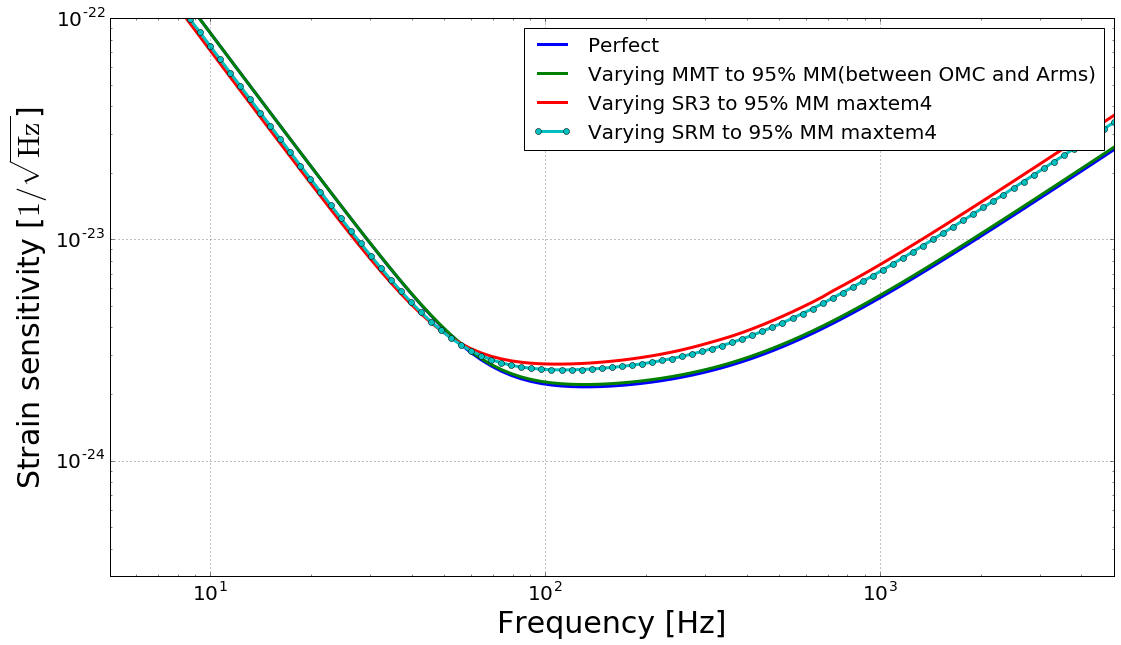

In [20]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)


pl.loglog(freq[0], np.real(darm_dict['perfect']),linewidth=3, label='Perfect')
pl.loglog(freq[0], np.real(darm_dict['Varying MMT to 95% MM(between OMC and Arms)']),linewidth=3\
          ,label='Varying MMT to 95% MM(between OMC and Arms)')
pl.loglog(freq[0], np.real(darm_dict['Varying SR3 to 95% MM']),linewidth=3,label='Varying SR3 to 95% MM maxtem4')
pl.loglog(freq[0], np.real(darm_dict['Varying SRM to 95% MM']),'o-',linewidth=3,label='Varying SRM to 95% MM maxtem4')


pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.savefig("ht_varyingCompareAll_noSqz.png")

pl.show()
